In [6]:
import torch


## Render our simple world with no pendulum (it's empty)


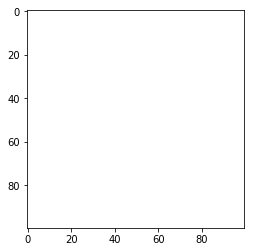

In [30]:
img = torch.zeros((100,100)).cuda()

import matplotlib.pyplot as plt
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

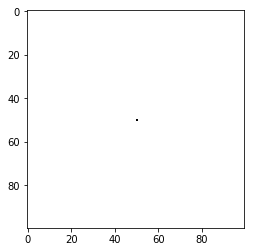

In [31]:
# Flip a pixel

img[50,50] = 1.0
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get a state of the pendulum

<p align="center">
  <img src="simple_pend.svg" width="250"/>
</p>

In [19]:
## parameters

l = 10.0   # length in pixels
g = 9.8    # gravity in m/s**2

## state

theta    = 0 # angle from down
thetadot = 0 # 

state = torch.cuda.FloatTensor([theta, thetadot])
print state


 0
 0
[torch.cuda.FloatTensor of size 2 (GPU 0)]



## Convert state of pendulum to line segment

In [50]:
base = torch.cuda.FloatTensor([0,0])  # in world coordinates

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50

print base, "in world"
base_in_img = convert_world_to_img_coordinates(base)
print base_in_img, "in image"

length_x = l * torch.cos(state[0:1])
print length_x
length_y = l * torch.sin(state[1:])
print length_y

length = torch.cat((length_x, length_y))

end = base + length
print end
end_in_img = convert_world_to_img_coordinates(end)
print end_in_img


 0
 0
[torch.cuda.FloatTensor of size 2 (GPU 0)]
 in world

 50
 50
[torch.cuda.FloatTensor of size 2 (GPU 0)]
 in image

 10
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 10
  0
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 60
 50
[torch.cuda.FloatTensor of size 2 (GPU 0)]



## Find all pixels close enough to line segment


In [185]:
import numpy as np
from numpy import arccos, array, dot, pi
from numpy.linalg import det, norm

# from: https://gist.github.com/nim65s/5e9902cd67f094ce65b0
def distance_numpy(A, B, P):
    """ segment line AB, point P, where each one is an array([x, y]) """
    if all(A == P) or all(B == P):
        return 0
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > pi / 2:
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > pi / 2:
        return norm(P - B)
    return abs(dot(A - B, P[::-1]) + det([A, B])) / norm(A - B)

A = np.array([0,1])
B = np.array([10,0])

P = np.array([1,2])

print A, B, P

print distance_numpy(A, B, P)

print P - A
print (P - A) / norm(P - A)
print (P - A) / norm(P - A), (B - A) / norm(B - A)
print dot((P - A) / norm(P - A), (B - A) / norm(B - A))
print arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A)))
print arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > pi / 2
print P[::-1]
print dot(A - B, P[::-1])
print det([A, B])
print dot(A - B, P[::-1]) + det([A, B])
print abs(dot(A - B, P[::-1]) + det([A, B]))

[0 1] [10  0] [1 2]
2.8856078516089685
[1 1]
[0.70710678 0.70710678]
[0.70710678 0.70710678] [ 0.99503719 -0.09950372]
0.6332377902572626
0.8850668158886105
False
[2 1]
-19
-10.000000000000002
-29.0
29.0


In [186]:
A = torch.from_numpy(A).type(torch.FloatTensor)
B = torch.from_numpy(B).type(torch.FloatTensor)
P = torch.from_numpy(P).type(torch.FloatTensor)

def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch.dot(A - B, torch_flip(P)) + torch_det(A, B)) / (A - B).norm()

    
print distance_pytorch(A, B, P)

print P - A
print (P - A) / (P-A).norm()
print (P - A) / (P - A).norm(), (B - A) / (B - A).norm()
print torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), (B - A) / (B - A).norm())])
print torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), (B - A) / (B - A).norm())]))
print torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), (B - A) / (B - A).norm())])) > pi/2
if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), (B - A) / (B - A).norm())])) > pi/2).all():
    print "yes"
    
def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]
    
print torch_flip(P)
print torch.dot(A-B, torch_flip(P))
print torch_det(A,B)
print torch.dot(A - B, torch_flip(P)) + torch_det(A, B)


2.88560785161

 1
 1
[torch.FloatTensor of size 2]


 0.7071
 0.7071
[torch.FloatTensor of size 2]


 0.7071
 0.7071
[torch.FloatTensor of size 2]
 
 0.9950
-0.0995
[torch.FloatTensor of size 2]


 0.6332
[torch.FloatTensor of size 1]


 0.8851
[torch.FloatTensor of size 1]


 0
[torch.ByteTensor of size 1]


 2
 1
[torch.FloatTensor of size 2]

-19.0
-10.0
-29.0
